In [181]:
import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/sample_submission.csv
data/test.csv
data/train.csv


In [182]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.metrics import f1_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

In [183]:
# df_base = pd.read_csv('/kaggle/input/scoring-base-train/base_train.csv')
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [184]:
# Посмотрим на предлагаемый датасет.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Склеить с базовым (baseline) не получится, так как разная размерность. Будет много пропусков.

#### Описание полей

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [185]:
# Уникальные значения признаков
df_train.nunique(dropna=False)

client_id           73799
app_date              120
education               6
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           69096
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                966
sna                     4
first_time              4
foreign_passport        2
default                 2
dtype: int64

In [186]:
# Проверим пропуски в датасете
df_train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

Пропуски содержит education, позже исправим.

<AxesSubplot:xlabel='default', ylabel='Count'>

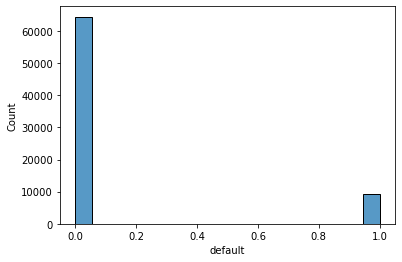

In [187]:
#Посмотрим на целевую переменную
sns.histplot(df_train.default)

Слишком большой дисбаланс. Данное положение значительно влияет на конечный результат и на анализ по метрикам. Попробуем исправить параметром class_weight='balanced'


In [188]:
df_train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

In [189]:
# Склеим с тестовым датасетом на время анализа данных.
df_train['test']=0
df_test['test']=1

df_train = df_train.append(df_test, ignore_index=True)

In [190]:
df_train.sample(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test
28271,81056,29MAR2014,SCH,M,50,N,N,1,0,-1.743216,0,40,2,3,20000,2,2,N,0.0,0
22180,53655,02MAR2014,SCH,F,46,N,N,0,1,-1.508508,1,40,2,3,10000,1,1,N,0.0,0
55621,85221,02APR2014,SCH,F,42,N,N,2,0,-1.081527,10,50,1,3,25000,1,2,N,1.0,0
75329,92294,08APR2014,SCH,M,26,N,N,0,0,-1.770187,3,40,2,3,23000,3,2,N,NaN,1
75096,17716,24JAN2014,SCH,M,36,N,N,0,0,-1.652213,0,50,1,2,5000,1,3,N,NaN,1
52838,105141,23APR2014,UGR,F,51,N,N,0,0,-2.845945,1,50,2,3,30000,1,3,N,0.0,0
23336,3598,09JAN2014,UGR,M,41,N,N,0,1,-1.948237,2,50,2,3,43000,4,1,N,0.0,0
56559,93082,09APR2014,GRD,F,45,Y,Y,0,0,-1.832078,2,40,2,3,90000,3,1,N,1.0,0
5662,71378,19MAR2014,SCH,F,51,N,N,0,0,-0.877159,4,40,1,2,12000,2,1,N,0.0,0
39664,52452,01MAR2014,SCH,F,42,N,N,0,0,-2.157743,4,60,2,3,20000,1,4,N,0.0,0


Сгруппируем признаки в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

In [191]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']

# числовые переменные
num_cols = ['age', 'score_bki', 'decline_app_cnt',  'bki_request_cnt', 'region_rating', 'income']

In [192]:
# С помощью LabelEncoder преобразуем бинарные переменные
def bin_encoder(data):
    label_encoder = LabelEncoder()

    for column in bin_cols:
        data[column] = label_encoder.fit_transform(data[column])
    return data

In [193]:
df_train = bin_encoder(df_train)
df_test = bin_encoder(df_test)

<AxesSubplot:>

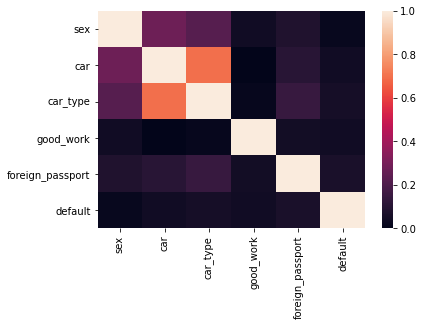

In [194]:
# Посмотрим на корреляцию биарных признаков
sns.heatmap(df_train[bin_cols+['default']].corr().abs(), vmin=0, vmax=1)

Бросается в глаза корреляция между 'car', 'car_type'. Корреляция очевидна, но думаю не стоит убирать один из признаков, так как иметь машину или возможность купить иномарку часто показательна.

In [195]:
df_train[bin_cols+['default']].corr()

,sex,car,car_type,good_work,foreign_passport,default
sex,1.000000,0.277470,0.224822,-0.044026,0.085924,0.019619
car,0.277470,1.000000,0.698760,0.001565,0.106893,-0.043161
car_type,0.224822,0.698760,1.000000,0.016160,0.145373,-0.057484
good_work,-0.044026,0.001565,0.016160,1.000000,0.048491,-0.043361
foreign_passport,0.085924,0.106893,0.145373,0.048491,1.000000,-0.066718
default,0.019619,-0.043161,-0.057484,-0.043361,-0.066718,1.000000


Согласно матрице, наиболее влиятельные признаки это паспорт и иномарка

<AxesSubplot:>

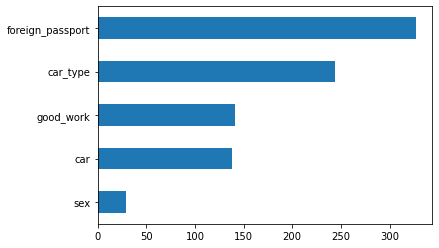

In [196]:
# Проверим значимость бинарных переменных
imp_num = Series(f_classif(df_train.dropna()[bin_cols], df_train.dropna()['default'])[0], index = bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Полиномиальные признаки на основе бинарных переменных какого-либо значимого эффекта не дали.

In [197]:
# На основе бинарных сформируем категориальный признак, который отображает материальное положение в целом (просуммируем 'активы').
# df_train['sum_bin'] = df_train[bin_cols].drop('sex', axis=1).sum(axis=1)
# df_test['sum_bin'] = df_test[bin_cols].drop('sex', axis=1).sum(axis=1)

# cat_cols.append('sum_bin')

Категориальные признаки

In [198]:
# education у нас был с пропусками, смотрим значения
df_train.education.value_counts(dropna = False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

In [199]:
# Избавимся от пропусков путём заполнения наиболее встречающегося значения. Фаворит SCH.
def education_fillna(data):
    data.education.fillna('SCH', inplace=True)
    return data

In [200]:
df_train = education_fillna(df_train)
df_test = education_fillna(df_test)

In [201]:
# Преобразуем education 
def education_encoder(data):
    label_encoder = LabelEncoder()
    data['education'] = label_encoder.fit_transform(data['education'])
    return data

In [202]:
df_train = education_encoder(df_train)
df_test = education_encoder(df_test)

<AxesSubplot:>

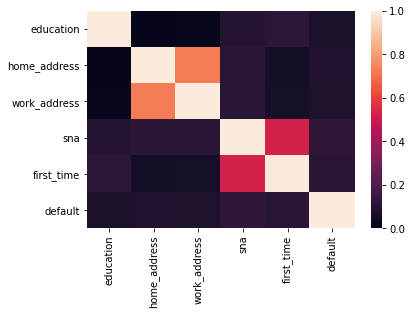

In [203]:
# Посмотрим на корреляцию категориальных признаков
sns.heatmap(df_train[cat_cols + ['default']].corr().abs(), vmin=0, vmax=1)

In [204]:
df_train[cat_cols + ['default']].corr()

,education,home_address,work_address,sna,first_time,default
education,1.000000,0.011215,0.012201,0.095763,-0.120016,0.071558
home_address,0.011215,1.000000,0.726535,0.114541,-0.058430,0.084637
work_address,0.012201,0.726535,1.000000,0.111162,-0.062266,0.081582
sna,0.095763,0.114541,0.111162,1.000000,-0.526594,0.125832
first_time,-0.120016,-0.058430,-0.062266,-0.526594,1.000000,-0.105579
default,0.071558,0.084637,0.081582,0.125832,-0.105579,1.000000


sna и first_time выделяются

<AxesSubplot:>

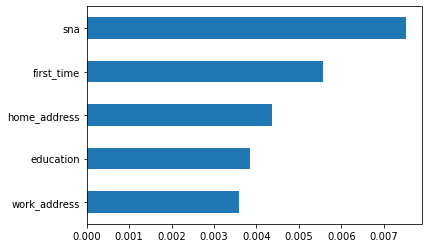

In [205]:
# Проверим значимость категориальных переменных
imp_cat = Series(mutual_info_classif(df_train.dropna().dropna()[cat_cols], df_train.dropna()['default'],
                                     discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

array([[<AxesSubplot:title={'center':'education'}>,
        <AxesSubplot:title={'center':'home_address'}>],
       [<AxesSubplot:title={'center':'work_address'}>,
        <AxesSubplot:title={'center':'sna'}>],
       [<AxesSubplot:title={'center':'first_time'}>, <AxesSubplot:>]],
      dtype=object)

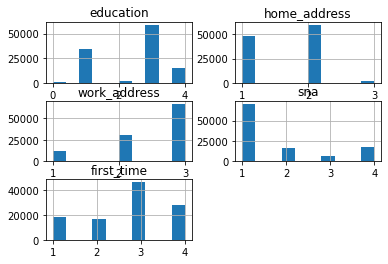

In [206]:
df_train[cat_cols].hist()

Числовые признаки

In [207]:
# Думаю, что дату подачи заявки надо отнести к числовым признакам
df_train.app_date.head()

0    01FEB2014
1    12MAR2014
2    01FEB2014
3    23JAN2014
4    18APR2014
Name: app_date, dtype: object

In [208]:
# Один из вариантов преобразования - привести к timestamp
def strdate_to_int(data):
    data.app_date = data.app_date.apply(lambda x: int(datetime.strptime(x,'%d%b%Y').timestamp()))
    return data

In [209]:
df_train = strdate_to_int(df_train)
df_test = strdate_to_int(df_test)
num_cols.append('app_date')

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'score_bki'}>,
        <AxesSubplot:title={'center':'decline_app_cnt'}>],
       [<AxesSubplot:title={'center':'bki_request_cnt'}>,
        <AxesSubplot:title={'center':'region_rating'}>,
        <AxesSubplot:title={'center':'income'}>],
       [<AxesSubplot:title={'center':'app_date'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

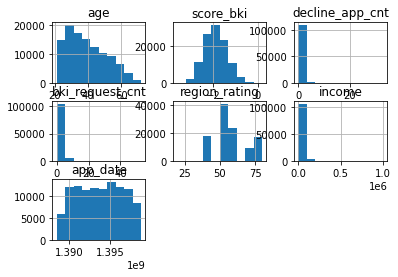

In [210]:
df_train[num_cols].hist()

In [211]:
# Попробуем привести к нормальному распределению путём логарифмирования
def log_num_cols(data):
    for i in ['age', 'decline_app_cnt', 'bki_request_cnt', 'region_rating', 'income']:
        data[i] = np.log(data[i]+1)
    return data

In [212]:
df_train = log_num_cols(df_train)
df_test = log_num_cols(df_test)

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'score_bki'}>,
        <AxesSubplot:title={'center':'decline_app_cnt'}>],
       [<AxesSubplot:title={'center':'bki_request_cnt'}>,
        <AxesSubplot:title={'center':'region_rating'}>,
        <AxesSubplot:title={'center':'income'}>],
       [<AxesSubplot:title={'center':'app_date'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

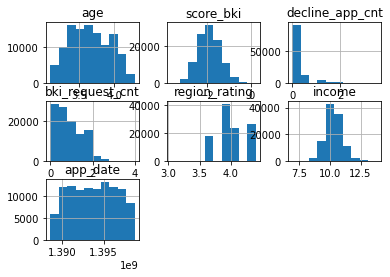

In [213]:
df_train[num_cols].hist()

C:\Users\belichenko.as\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


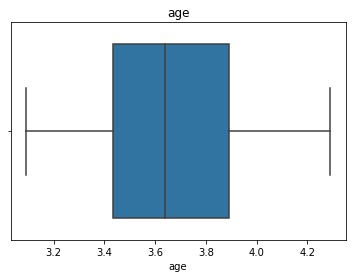

C:\Users\belichenko.as\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


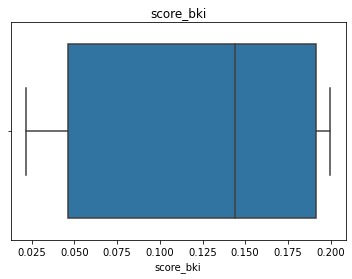

C:\Users\belichenko.as\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


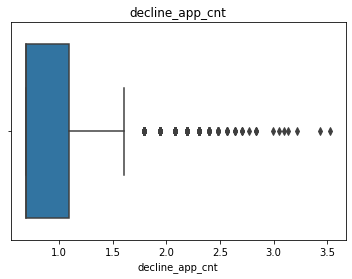

C:\Users\belichenko.as\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


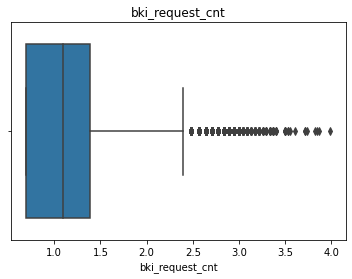

C:\Users\belichenko.as\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


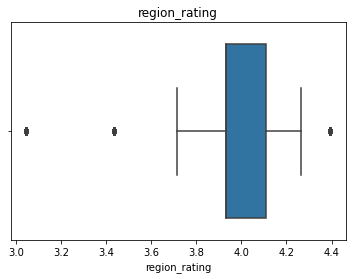

C:\Users\belichenko.as\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


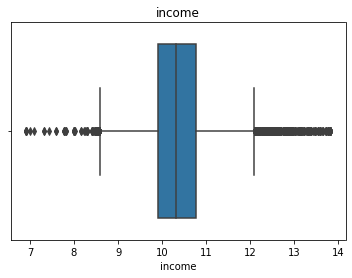

C:\Users\belichenko.as\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


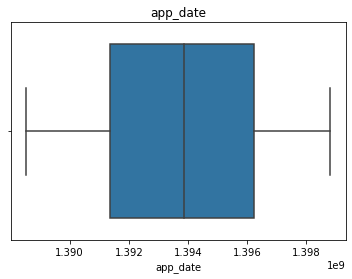

In [214]:
# Проверим выбросы
for i in num_cols:
    plt.figure()
    sns.boxplot(df_train[i][df_train[i] > 0].dropna())
    plt.title(i)
    plt.show()

decline_app_cnt, bki_request_cnt, income содержат заметное количество выбросов.

In [215]:
# Функция для расчёта границ выбросов
def emissions(col):
    median = col.median()
    IQR = col.quantile(0.75) - col.quantile(0.25)
    perc25 = col.quantile(0.25)
    perc75 = col.quantile(0.75)
    return perc25 - 1.5*IQR, perc75 + 1.5*IQR

In [216]:
# Отсечение выбросов decline_app_cnt. Сильно отбросило назад. Убираем.
#emiss = emissions(df_train['decline_app_cnt'])

#df_train = df_train[df_train.decline_app_cnt.between(emiss[0],emiss[1])]

In [217]:
# На итоговом тестировании падают показатели.
# emiss = emissions(df_train['bki_request_cnt'])

#df_train = df_train[df_train.bki_request_cnt.between(emiss[0],emiss[1])]

In [218]:
# На итоговом тестировании падают показатели.
# emiss = emissions(df_train['income'])

#df_train = df_train[df_train.income.between(emiss[0],emiss[1])]

<AxesSubplot:>

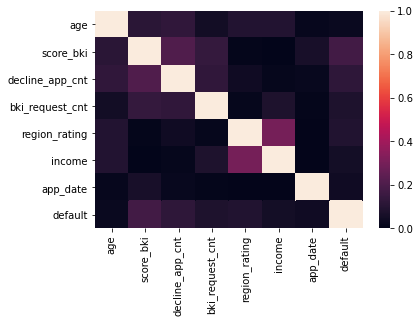

In [219]:
# Проверим корреляцию числовых признаков
sns.heatmap(df_train.dropna()[num_cols + ['default']].corr().abs(), vmin=0, vmax=1)

In [220]:
def num_scaler(data):
    # Стандартизация числовых переменных
    data[num_cols] = StandardScaler().fit_transform(data[num_cols].values)
    return data

In [221]:
df_train = num_scaler(df_train)
df_test = num_scaler(df_test)

In [222]:
# Добавим полиномиальных признаков
def calculate_poly(data):
    # список новых признаков
    columns = list()
    
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(data)
    # Преобразуем в df
    df_poly = pd.DataFrame(X_poly)
    
    for x in df_poly.columns:
        columns.append(x)
    
    return df_poly, columns

In [223]:
df_poly, poly_columns = calculate_poly(df_train[num_cols])
df_train = pd.concat([df_train, df_poly], axis=1)
df_train.sample(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,26,27,28,29,30,31,32,33,34,35
85670,31240,-0.747335,3,0,0.533644,0,0,3.417839,0,0.533368,...,0.111420,0.118554,-0.349747,-0.249458,0.126144,-0.372139,-0.265429,1.097849,0.783045,0.558510
65297,61647,0.250298,3,1,1.040852,0,0,-0.418815,0,-0.012254,...,0.079406,-0.454755,-0.149119,-0.070531,2.604372,0.854003,0.403932,0.280038,0.132454,0.062649
101583,51480,-0.092638,1,0,-1.007707,0,0,1.499512,1,-0.632547,...,0.079406,0.123856,0.014888,0.026105,0.193188,0.023222,0.040717,0.002791,0.004894,0.008582
100092,22957,-0.996743,3,1,-0.059496,1,0,-0.418815,0,-1.235218,...,0.593768,0.273679,0.160952,-0.768054,0.126144,0.074186,-0.354011,0.043629,-0.208196,0.993497
71167,70588,0.468530,3,0,-1.671590,0,0,-0.418815,1,1.386716,...,0.079406,-0.100083,0.014888,-0.132027,0.126144,-0.018765,0.166407,0.002791,-0.024754,0.219520
84329,79088,0.749114,3,0,0.120447,0,0,-0.418815,0,-0.270417,...,1.921413,2.236979,0.233482,1.038385,2.604372,0.271828,1.208925,0.028372,0.126180,0.561172
47340,62497,0.250298,3,1,1.483906,0,0,-0.418815,0,-0.606314,...,0.079406,-0.454755,0.014888,-0.070531,2.604372,-0.085264,0.403932,0.002791,-0.013224,0.062649
43253,108594,1.746747,1,1,-0.347997,0,0,-0.418815,0,0.009680,...,0.079406,-0.100083,0.088635,-0.492216,0.126144,-0.111716,0.620389,0.098937,-0.549427,3.051125
94885,81459,0.811466,3,1,-0.347997,0,0,-0.418815,0,-1.354933,...,0.593768,0.273679,-0.040712,0.625286,0.126144,-0.018765,0.288207,0.002791,-0.042873,0.658477
31163,32062,-0.747335,3,0,-0.773745,0,0,-0.418815,0,-0.789401,...,0.079406,0.123856,0.178893,0.210592,0.193188,0.279034,0.328477,0.403029,0.474442,0.558510


In [224]:
# И тоже самое для тестовых данных
df_poly, poly_columns = calculate_poly(df_test[num_cols])
df_test = pd.concat([df_test, df_poly], axis=1)

In [225]:
# Расширяем список числовых колонок
num_cols += poly_columns

Перед обучением модели, преобразуем ещё категориальные признаки с помощью OneHotEncoder

In [226]:
def cat_o_h_e(data):
    cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
    return cat

In [227]:
# Для тренировочных данных исключаем тестовые
X_cat = cat_o_h_e(df_train[df_train.test==0])
# Тестовые
XT_cat = cat_o_h_e(df_test)

In [228]:
# Собираем обработанные данные.
def hstack(data, cat):
    X = np.hstack([data[bin_cols + num_cols].values, cat])
    return X

In [229]:
X = hstack(df_train[df_train.test==0], X_cat)
Y = df_train[df_train.test==0]['default'].values

XT = hstack(df_test, XT_cat)

In [230]:
# Разбиваем на тренировочные и валидационные данные. 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

sm = SMOTE (#sampling_strategy = 0.9,
    random_state=0,
    k_neighbors=4)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 

ros = RandomOverSampler(random_state=0) 
X_train, y_train = ros.fit_sample(X_train, y_train)

In [231]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\belichenko.as\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

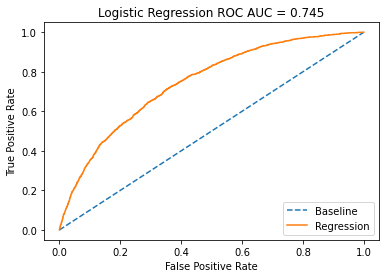

In [232]:
probs = model.predict_proba(X_test)
probs = probs[:,1]

y_predict = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [233]:
def check_metrics(y_test, y_predict):
    print('Matrix: \n', confusion_matrix(y_test, y_predict))
    print('F1_score: \n',f1_score(y_test, y_predict))

In [234]:
check_metrics(y_test, y_predict)

Matrix: 
 [[12890    43]
 [ 1788    39]]
F1_score: 
 0.040859088528025146


Неплохой ROC AUC, но низкий F1_score и матрица показывает много ошибок первого рода.

In [235]:
# Подберём гиперпараметры
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}
     ]
     
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model.get_params()
best_parameters

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

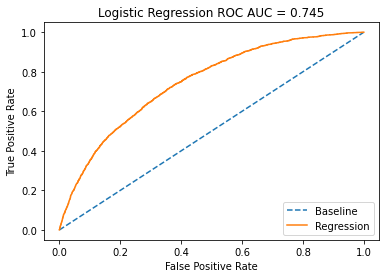

In [241]:
model = LogisticRegression(C=1.0,
                            class_weight='balanced',
                            dual=False,
                            fit_intercept=True,
                            intercept_scaling=1,
                            l1_ratio=None,
                            max_iter=100,
                            multi_class='auto',
                            n_jobs=None,
                            penalty='l1',
                            random_state=None,
                            solver='liblinear',
                            tol=0.0001,
                            verbose=0,
                            warm_start=False)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

y_predict = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [242]:
check_metrics(y_test, y_predict)

Matrix: 
 [[8613 4320]
 [ 572 1255]]
F1_score: 
 0.3390975412050797


ROC AUC остался на уровне. F1-score значительно улучшился и судя по confusion-matrix ошибки первого рода значительно сократились, при этом выросли второго рода. Некий паритет.

In [238]:
# Посмотрим в каком формате надо вернуть ответ
df_sub = pd.read_csv('data/sample_submission.csv')
df_sub.sample()

,client_id,default
5614,71546,0.022694


In [239]:
# Передаём нашей модели тестовые данные
y_sub = model.predict(XT)

probs = model.predict_proba(XT)
probs = probs[:,1]
probs

array([0.22123785, 0.828307  , 0.3230876 , ..., 0.75738818, 0.59770778,
       0.72874084])

In [240]:
# Формируем файл
df_test['default'] = probs
df_test[['client_id', 'default']].to_csv('submission.csv', index=False)
df_test[['client_id', 'default']].head(10)

,client_id,default
0,74835,0.221238
1,17527,0.828307
2,75683,0.323088
3,26883,0.382088
4,28862,0.125014
5,99881,0.597744
6,26630,0.800665
7,79934,0.190737
8,16605,0.142985
9,105449,0.096054


Заключение: В случае с несбалансированной целевой переменной получаются низкие значения f1-score. При этом, confusion_matrix показывала жуткое значение ошибок первого рода. Докручивание гиперпараметров приводило матрицу к более меннее адекватному виду и повышает f1-score. Чаще всего, гиперпараметры не оказывали сильного влияния на показатель roc auc.